In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# DataLoader

In [2]:
# dataset
class Dataset(Dataset):
  
    def __init__(self):
        'Initialization'
        
    def __len__(self):
        'Denotes the total number of samples'
        return 1200
        #return 6 #for testing code
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data
        X = torch.load('data/true_data/{}.pt'.format(index))
        return X

In [3]:
BATCH_SIZE = 10

In [4]:
from sklearn.model_selection import train_test_split
dataset = Dataset()
train_index, valid_index = train_test_split(range(len(dataset)), test_size=0.2)
train_data = Subset(dataset,train_index)
valid_data = Subset(dataset,valid_index)
dataloader_train = DataLoader(dataset = train_data, batch_size=BATCH_SIZE,
                                         shuffle=True)
dataloader_valid = DataLoader(dataset=valid_data, batch_size=BATCH_SIZE,shuffle=False)
# Grab a batch of real images from the dataloader
"""real_batch = next(iter(dataloader_valid))

# Plot the real images
plt.axis("off")
plt.title("Real Images")
print(real_batch[15][0].shape)
plt.imshow(real_batch[15][0])
plt.colorbar()
plt.show()"""

'real_batch = next(iter(dataloader_valid))\n\n# Plot the real images\nplt.axis("off")\nplt.title("Real Images")\nprint(real_batch[15][0].shape)\nplt.imshow(real_batch[15][0])\nplt.colorbar()\nplt.show()'

# Model

In [13]:

class Self_Attention(nn.Module):
    """
    #Self-AttentionのLayer
    """
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()#不明
        #i*1の畳み込み層によるpointwise convolutionを用意
        self.query_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成画像サイズ確認
        self.key_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成
        self.value_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim,kernel_size=1)#Conv2dを生成)
        #AttentionMap用の正規化softmax
        self.softmax=nn.Softmax(dim=-2)
        #入力xとAttentionMapを足すときの係数
        self.gamma=nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        #入力
        X=x
        #畳み込みをしてからサイズ変更B,C',W,H->B,C',N
        proj_query=self.query_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        proj_query=proj_query.permute(0,2,1)#転置#サイズ　B,N,C'
        proj_key=self.key_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        #かけざん
        S=torch.bmm(proj_query,proj_key)#サイズB,N,N
        
        #規格化
        attention_map_T=self.softmax(S)#正規化
        attention_map=attention_map_T.permute(0,2,1)#サイズ:B,N,N(?)#出力しないから転置不要
        #Attentionmapを計算
        proj_value=self.value_conv(X).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C,N
        #o=torch.bmm(proj_value,attention_map_T.permute)
        o=torch.bmm(proj_value,attention_map.permute(0,2,1))#出力しないから転置不要
        
        #AttentionmapのoのテンソルサイズをXにそろえる->計算
        o=o.view(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        out=x+self.gamma*o
        return out #,attention_map#attention_mapは学習には不要

In [14]:
# Generator
# Generator Code
#attention2を使うとメモリ消費が激しいため除いています。使う場合は######3の部分をコメントアウトを解除してください
class Generator(nn.Module):
    def __init__(self,nz=20,DIM=64):#今のところ入力は[1,20,5,4]
        super(Generator, self).__init__()
        """
        self.layer0 = nn.Sequential(
            # input is Z, going into a convolution
            nn.utils.spectral_norm(nn.ConvTranspose2d( nz, DIM * 64, kernel_size=3, stride=1, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 64),
            nn.ReLU(inplace=True))
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(DIM * 64, DIM * 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 32),
            nn.ReLU(inplace=True))
        
        self.layer1_sub=nn.Sequential(
            # input is Z, going into a convolution
            nn.utils.spectral_norm(nn.ConvTranspose2d( nz, DIM * 32, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 32),
            nn.ReLU(inplace=True))
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(DIM * 32, DIM * 16, kernel_size=4, stride=2, padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d( DIM * 16, DIM * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(DIM * 8),
            nn.ReLU(inplace=True))
        """
        self.layer3_sub= nn.Sequential(
            # input is Z, going into a convolution
            nn.utils.spectral_norm(nn.ConvTranspose2d( nz, DIM * 8, kernel_size=4, stride=2, padding=[0,1], bias=False)),
            nn.BatchNorm2d(DIM * 8),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d( DIM * 8, DIM * 4, kernel_size=(4,3), stride=2, padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(inplace=True))
        #かなりやばい学習方法を使う#入力の形を適度に決める
        self.self_attention1 = Self_Attention(in_dim=DIM * 4)
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d( DIM * 4, DIM * 2, kernel_size=4, stride=(2,3), padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM * 2),
            nn.ReLU(inplace=True))
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d( DIM * 2, DIM, kernel_size=4, stride=(2,3), padding=(0,1), bias=False),
            nn.BatchNorm2d(DIM),
            nn.ReLU(inplace=True))
        #self.self_attention2 = Self_Attention(in_dim=DIM)######3
        self.layer7 = nn.Sequential(
            nn.ConvTranspose2d( DIM, 1, kernel_size=(5,3), stride=(3,2), padding=1, bias=False),
            nn.Tanh()   
        )
    def forward(self, x):
        #print(x.shape)
        """
        print(x.shape)
        img_transformed = x[0][0].detach().numpy()
        plt.imshow(img_transformed)
        plt.show()
        check=input("ok")
        #"""
        #out = self.layer0(x)
        #out=self.layer1(out)
        #out = self.layer1_sub(x)
        #out = self.layer2(out)
        #out = self.layer3(out)
        out = self.layer3_sub(x)#5*5
        #print(out.shape)
        """
        print(out.shape)
        img_transformed = out[0][0].detach().numpy()
        plt.imshow(img_transformed)
        plt.show()
        check=input("ok")
        #"""
        out = self.layer4(out)#10*10
        #print(out.shape)
        out=self.self_attention1(out)#10*10
        #out, attention_map1 = self.self_attention1(out)#10*10
        """
        print(out.shape)
        img_transformed = out[0][0].detach().numpy()
        plt.imshow(img_transformed)
        plt.show()
        check=input("ok")"""
        out = self.layer5(out)
        #print(out.shape)
        out = self.layer6(out)
        #print(out.shape)
        #print("a")
        #out=self.self_attention2(out)###########3
        #out, attention_map2 = self.self_attntion2(out)
        out = self.layer7(out)
        #print(out.shape)
        return out
    def sample_latent(self,num_samples):
        return torch.randn((num_samples,nz,1,1))

In [15]:
#識別器4層
#DCGANでありSAGANではないメモリ節約、後日改良
#image_size->DIM
#z_dim->nz
class Discriminator(nn.Module):
    def __init__(self,DIM=64):#nz不要説
        super(Discriminator,self).__init__()
        #1層:真画像、偽画像->image_size
        #input=1,330,261
        self.layer1=nn.Sequential(
            nn.Conv2d(1,DIM,kernel_size=4,stride=3,padding=1, bias=False),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #2層:image_size->image_size*2
        self.layer2=nn.Sequential(
            nn.Conv2d( DIM, DIM*2, kernel_size=4, stride=3, padding=(0,1), bias=False),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #3層:image_size*2->image_size*4
        self.layer3=nn.Sequential(
            nn.Conv2d(DIM * 2, DIM * 4, kernel_size=4, stride=3, padding=(0,1), bias=False),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #4層:image_size*4->image_size*8
        self.layer4=nn.Sequential(
            nn.Conv2d(DIM * 4, DIM * 8, kernel_size=4, stride=3, padding=(0,1), bias=False),#input1,output64
            nn.LeakyReLU(0.1,inplace=True))
        #最終層:image_size*8->真偽
        self.last=nn.Conv2d(DIM * 8,1, kernel_size=3, stride=1, padding=0, bias=False)
    
    def forward(self,x):#層を増やすときはここも変更すること#ある意味ここはfor文+辞書処理でもいいかもね
        #print(x.shape)#[1, 1, 330, 261]
        out=self.layer1(x)
        #print(out.shape)#[1, 64, 110, 87]
        out=self.layer2(out)
        #print(out.shape)#[1, 128, 54, 44]
        out=self.layer3(out)
        #print(out.shape)#[1,256,26,15]
        out=self.layer4(out)
        #print(out.shape)#[1,512,8,5]
        out=self.last(out)
        #print(out.shape)#[1,1,5,4]
        return out

In [16]:
G=Generator(nz=20,DIM=64)
input_z=torch.randn(1,400)#テンソル(1,20)
input_z=input_z.view(1,20,5,4)
fake_images=G(input_z)
print(fake_images.shape)

torch.Size([1, 1, 330, 261])


In [17]:
D=Discriminator(DIM=64)####################

d_out=D(fake_images)
print(d_out.shape)
print(nn.Sigmoid()(d_out))#

torch.Size([1, 1, 1, 1])
tensor([[[[0.4954]]]], grad_fn=<SigmoidBackward>)


In [18]:
a=dataloader_train.batch_size
print(a)

10


In [19]:
def train_model(G,D,dataloader,num_epochs):#ラベルミスあるかも
    #GPU確認
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス:", device)
    
    g_lr=0.001
    d_lr=0.004#学習率
    beta1=0.0
    beta2=0.9
    g_optimizer=torch.optim.Adam(G.parameters(),g_lr,[beta1,beta2])
    d_optimizer=torch.optim.Adam(D.parameters(),d_lr,[beta1,beta2])
    
    #損失関数を定義
    criterion=nn.BCEWithLogitsLoss(reduction="mean")
    
    #パラメータをハードコーディング
    nz=20
    mini_batch_size=5
    
    #ネットワークをGPUへ
    G.to(device)
    D.to(device)
    
    G.train()#モデルを訓練モードに
    D.train()#モデルを訓練モードに
    
    #ネットワークがある程度固定であれば高速化させる
    torch.backends.cudnn.benchmark=True
    
    #画像の枚数
    num_train_imgs=len(dataloader.dataset)
    batch_size=dataloader.batch_size
    
    #イテレーションカウンタをセット
    iteration=1
    logs=[]
    
    #epochのループ
    for epoch in range(num_epochs):
        #開始時刻を保持
        t_epoch_start=time.time()
        epoch_g_loss=0.0
        epoch_d_loss=0.0
        #print("---")
        print("Epoch{}/{}".format(epoch,num_epochs))
        #print("---")
        #print("(train)")
        
        #データローダーからminibatchずつ取り出す
        for imges in dataloader:
            #1:Discriminatorの学習
            #minibatchサイズ1だとバッチノーマライゼーションでエラー発生
            if imges.size()[0]==1:
                continue
            #GPU使用できるときGPUに流す
            imges=imges.to(device)
            
            #ラベル作成#下に修正作業あり
            mini_batch_size=imges.size()[0]
            label_real=torch.full((mini_batch_size,),1).to(device)
            label_fake=torch.full((mini_batch_size,),0).to(device)
            
            #真画像判定
            d_out_real=D(imges)
            
            #偽画像生成&判定##################################################入力を[1,20,5,4]に設定しています
            input_z=torch.randn(mini_batch_size,nz*20).to(device)
            input_z=input_z.view(mini_batch_size,nz,5,4)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            label_real=label_real.type_as(d_out_real.view(-1))
            d_loss_real=criterion(d_out_real.view(-1),label_real)
            label_fake=label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake=criterion(d_out_fake.view(-1),label_fake)
            d_loss=d_loss_real+d_loss_fake
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            d_loss.backward()
            d_optimizer.step()
            #print("ここまでOK")
            #2:Generatorの学習
            #偽画像生成&判定
            input_z=torch.randn(mini_batch_size,nz*20).to(device)#minibatch個のz_dim生成->GPUへ
            input_z=input_z.view(mini_batch_size,nz,5,4)#テンソルの形を変更
            fake_images=G(input_z)#偽画像生成
            d_out_fake=D(fake_images)#偽画像判定
            
            #誤差を計算
            #修正あり詳しくは->"https://github.com/YutaroOgawa/pytorch_advanced/issues/144"
            """label_real=label_real.type_as(d_out_real.view(-1))"""#計算でエラーが出たらここを変更
            g_loss=criterion(d_out_fake.view(-1),label_real)
            
            
            #誤差逆伝播
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            
            g_loss.backward()
            g_optimizer.step()
            
            #3:記録
            epoch_d_loss+=d_loss.item()
            epoch_g_loss+=g_loss.item()
            iteration+=1
        
        #epochのphaseごとのlossと正答率
        t_epoch_finish=time.time()
        #print("---")
        print("epoch{}||Epoch_D_Loss:{:.4f}||Epoch_G_Loss:{:.4f}".format(epoch,epoch_d_loss/batch_size,epoch_g_loss/batch_size))
        print("timer:{:.4f}sec.".format(t_epoch_finish-t_epoch_start))
        time.sleep(1.5)
        t_epoch_start=time.time()
        
        
    return G,D

In [20]:
#学習
num_epochs=10#回数を指定
G_update,D_update=train_model(G,D,dataloader=dataloader_train,num_epochs=num_epochs)

使用デバイス: cuda:0
Epoch0/10
epoch0||Epoch_D_Loss:414.0735||Epoch_G_Loss:236.2544
timer:11.7528sec.
Epoch1/10
epoch1||Epoch_D_Loss:508.7544||Epoch_G_Loss:111.7488
timer:5.9740sec.
Epoch2/10
epoch2||Epoch_D_Loss:333.9993||Epoch_G_Loss:135.8704
timer:5.9303sec.
Epoch3/10
epoch3||Epoch_D_Loss:455.7140||Epoch_G_Loss:243.1753
timer:5.9947sec.
Epoch4/10
epoch4||Epoch_D_Loss:93.0576||Epoch_G_Loss:279.3409
timer:6.0314sec.
Epoch5/10
epoch5||Epoch_D_Loss:99.4360||Epoch_G_Loss:434.4951
timer:6.1324sec.
Epoch6/10
epoch6||Epoch_D_Loss:80.8972||Epoch_G_Loss:757.8611
timer:6.0775sec.
Epoch7/10
epoch7||Epoch_D_Loss:117.0884||Epoch_G_Loss:954.9025
timer:6.0144sec.
Epoch8/10
epoch8||Epoch_D_Loss:63.6818||Epoch_G_Loss:1204.8882
timer:6.0198sec.
Epoch9/10
epoch9||Epoch_D_Loss:61.1922||Epoch_G_Loss:947.5053
timer:6.0353sec.


torch.Size([1, 1, 330, 261])


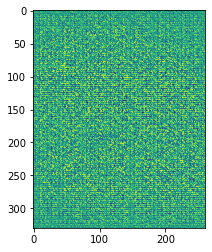

0.026903629302978516
2477185


In [26]:

import matplotlib.pyplot as plt
import time

%matplotlib inline

G = Generator(nz=20, DIM=64)

# 入力する乱数
input_z = torch.randn(1, 400)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(1, 20, 5, 4)

# 偽画像を出力
start=time.time()
fake_images= G(input_z)
end=time.time()
print(fake_images.shape)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed)
plt.show()

print(end-start)
#params_D = 0
params_G=0
#for p in D.parameters():
    #if p.requires_grad:
        #params_D += p.numel()
for p in G.parameters():
    if p.requires_grad:
        params_G += p.numel()
#print((13465803+14664877)/(3173251+2946099))
#print(params_D)  # 121898
print(params_G)

#"""

In [3]:
"""学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """
"""
def make_datapath_list():
    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/true_data/" + str(img_idx)+'.pt'
        train_img_list.append(img_path)
    return train_img_list"""

'\ndef make_datapath_list():\n    train_img_list = list()  # 画像ファイルパスを格納\n\n    for img_idx in range(5):\n        img_path = "./data/true_data/" + str(img_idx)+\'.pt\'\n        train_img_list.append(img_path)\n    return train_img_list'

In [18]:
"""画像の前処理クラス"""
"""
class ImageTransform():
    

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)"""

In [6]:
"""画像のDatasetクラス。PyTorchのDatasetクラスを継承"""
"""
class GAN_Img_Dataset(data.Dataset):
    

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed
"""

"\nclass GAN_Img_Dataset(data.Dataset):\n    \n\n    def __init__(self, file_list, transform):\n        self.file_list = file_list\n        self.transform = transform\n\n    def __len__(self):\n        '''画像の枚数を返す'''\n        return len(self.file_list)\n\n    def __getitem__(self, index):\n        '''前処理をした画像のTensor形式のデータを取得'''\n\n        img_path = self.file_list[index]\n        img = Image.open(img_path)  # [高さ][幅]白黒\n\n        # 画像の前処理\n        img_transformed = self.transform(img)\n\n        return img_transformed\n"

In [100]:
"""
注意事項
過去のコードと異なりz_dim->nzになっています。
image_size(隠れ層での変換後の配列を決める値)->DIMとしています。



class Generator(nn.Module):

    def __init__(self, nz=20, DIM=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(nz, DIM *64,
                                                      kernel_size=3, stride=2,padding=1)),
            nn.BatchNorm2d(DIM * 64),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 64, DIM * 16,
                                                      kernel_size=3, stride=2, padding=(0,1))),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 16, DIM * 4,
                                                      kernel_size=3, stride=2, padding=1)),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(inplace=True))

        # Self-Attention層を追加
        self.self_attntion1 = Self_Attention(in_dim=DIM * 4)

        self.layer4 = nn.Sequential(
            # Spectral Normalizationを追加
            nn.utils.spectral_norm(nn.ConvTranspose2d(DIM * 4, DIM,
                                                      kernel_size=3, stride=2, padding=1)),
            nn.BatchNorm2d(DIM),
            nn.ReLU(inplace=True))

        # Self-Attention層を追加
        self.self_attntion2 = Self_Attention(in_dim=DIM)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(DIM, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ


    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out#, attention_map1, attention_map2
#"""